In [1]:
import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals


def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df


def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df


def mean_std_col_df (df, col_name):
    
    col_list = df[col_name].to_list()
    
    cols_list_float = [float(val) for val in col_list]
    
    cols_list_float_np =np.array(cols_list_float)
    
    mean_col= np.mean(cols_list_float_np)
    std_col = np.std(cols_list_float_np)
    
    return mean_col, std_col


def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()
    return fig
    
    
def print_start_end_time(timestamp_col):
    
    time_stamp_list = timestamp_col.values
    start_timestamp = time_stamp_list[0]
    last_timestamp  = time_stamp_list[-1]
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    
    start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
    end_time  = dt.datetime.fromtimestamp(last_timestamp, tz)
    
    print("start time:" + str(start_time))
    print("end time:" + str(end_time))
    
    
    

def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []


    ##---outer loop to hnadle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)

            mean_val, std_val = mean_std_col_df(sensor_df_ii, data_col_name) 
            mean_cumm_list.append(mean_val)
            std_cumm_list.append(std_val)
            #event_interets_plot.append(offset_min_print)



            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot


def normalize_data (std_df, signal_col):
    
    
    signal = std_df[signal_col].to_list()
    
    
    signal_float =[float(val) for val in signal]
    
    signal_float_np = np.array(signal_float)
    
    
    mean_signal = np.mean(signal_float_np)
    
    mean_sub = signal_float_np - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    








### linux -------------------------

In [3]:
psychopy_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP039_061223/Psychopy_data/VP039_061223_DigiRelax_Experiment_2023-12-06_09h56.18.635.csv"
hr_shimmer_file_path =  "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP039_061223/Shimmer_data/2023-12-06_08.19.19_VP039_061223_SD_Session1/VP039_061223_Session1_Shimmer_6B1E_Calibrated_SD.csv"
skin_shimmer_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP039_061223/Shimmer_data/2023-12-06_08.19.19_VP039_061223_SD_Session1/VP039_061223_Session1_Shimmer_893E_Calibrated_SD.csv"

In [4]:
fol_path, file_name=os.path.split(psychopy_path)
sub_id=file_name[:-4]

### windows ---------------------

In [5]:
#psychopy_path ="D:/Datasets/data_sony_digiRelax/study/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
#hr_shimmer_file_path = "D:/Datasets/data_sony_digiRelax/study/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"
#skin_shimmer_file_path = "D:/Datasets/data_sony_digiRelax/study/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_893E_Calibrated_SD.csv"

## Psychopy

In [6]:
psychopy_df = read_manipulate_psychopy(psychopy_path)

In [7]:
psychopy_df

,Reference_time,baseline_instruction_ts,end_countDown_3min_ts,sam_e_ts,sam_a_ts,saliva_probe_1_ts,change_room_ts,tsst_prep_ts,end_countDown_5min_prep_ts,tsst_pres_ts,end_countDown_5min_pres_ts,end_countDown_5min_arithmetic_ts,tsst_end_exp_ts,saliva_probe_2_ts,relaxation_prep_ts,relaxation_ts,saliva_probe_3_ts,limeSurvey_ts,saliva_probe_4_ts
0,1.701853e+09,1.701853e+09,1.701853e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.701853e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.701853e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.701853e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.701853e+09,1.701854e+09,1.701854e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.701854e+09,1.701854e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.701854e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.701855e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.701855e+09,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,1.701855e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.701855e+09,NaN,NaN,NaN,NaN,NaN


## ----- Skin conductannce

In [8]:
timestamp_sensor_skin = "Shimmer_893E_Timestamp_Unix_CAL"
conductance_col_name = "Shimmer_893E_GSR_Skin_Conductance_CAL"

In [9]:
sk_cd_df=read_shimmer_sensor(skin_shimmer_file_path)
sk_cd_df = standardize_timestamps_shimmer(sk_cd_df, timestamp_sensor_skin)
sk_cd_df_selected = sk_cd_df[[timestamp_sensor_skin, conductance_col_name]]
sk_cd_df_selected=normalize_data (sk_cd_df_selected, conductance_col_name)
print_start_end_time(sk_cd_df[timestamp_sensor_skin])

start time:2023-12-06 09:54:33.668091+01:00
end time:2023-12-06 11:09:43.609497+01:00


/tmp/ipykernel_284316/6459626.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df["mean_norm"] = scaled_data


# ---Plotting data

In [10]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]
offset_min_list_new  = [[3], [5], [5,5], [10], [-5], [5]]

In [11]:
#conductance_col_name = "mean_norm"

In [12]:
mean_sk_cond_list,std_sk_cond_list, x_label_plot_sk =get_mean_std_event_list(psychopy_df, sk_cd_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_skin, conductance_col_name)

In [13]:
mean_sk_cond_list

[7.025322748492422,
 20.64108566032307,
 26.229497390227344,
 25.696876028313394,
 11.167378903005268,
 16.78246883978172,
 17.772804020892366]

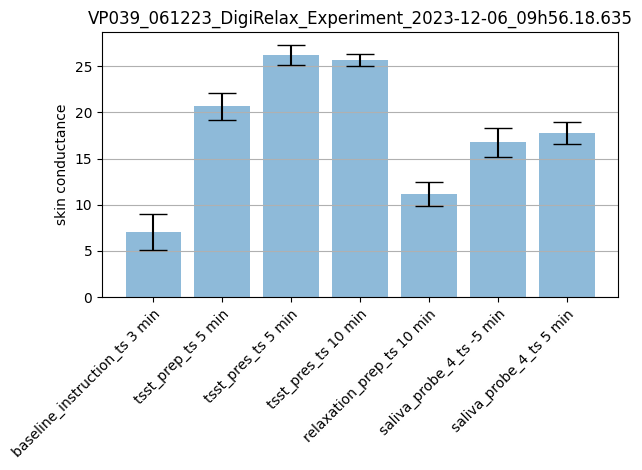

In [14]:
fig_sk= plot_mean_std(mean_sk_cond_list, std_sk_cond_list, x_label_plot_sk, sub_id, "skin conductance") 

## ----- Heart rate 

In [15]:
hr_df=read_shimmer_sensor(hr_shimmer_file_path)

In [16]:
timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
hr_col_name = "Shimmer_6B1E_ECGtoHR_LL_RA_CAL"

In [17]:
hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
hr_df_selected = hr_df[[timestamp_hr_col, hr_col_name]]
hr_df_selected=normalize_data (hr_df_selected, hr_col_name)
print_start_end_time(hr_df_selected[timestamp_hr_col])

start time:2023-12-06 09:54:34.750092+01:00
end time:2023-12-06 11:09:43.609467+01:00


/tmp/ipykernel_284316/6459626.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df["mean_norm"] = scaled_data


In [18]:
#hr_col_name = "mean_norm"

In [19]:
mean_hr_list,std_hr_list, x_label_plots_hr =get_mean_std_event_list(psychopy_df, hr_df_selected, event_interest_list_new, offset_min_list_new, timestamp_hr_col, hr_col_name)

In [20]:
mean_hr_list

[68.70473583953996,
 82.4635011740288,
 89.30518648253901,
 82.41346120900383,
 69.2112455757639,
 72.44659906540043,
 79.96263147801955]

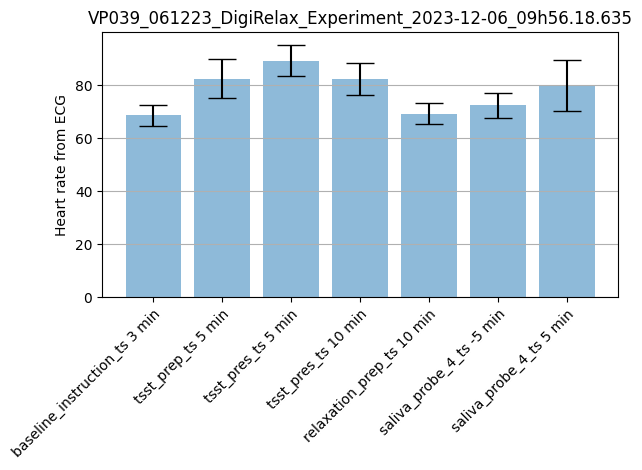

In [21]:
fig_hr=plot_mean_std(mean_hr_list, std_hr_list, x_label_plots_hr, sub_id, "Heart rate from ECG") 

## -- writting data

In [22]:
export_dict= {"subject_id":sub_id , 'event_interst': x_label_plot_sk, "mean_sk_cond":mean_sk_cond_list , "std_sk_cond": std_sk_cond_list , "mean_hr":mean_hr_list,  "std_hr": std_hr_list}

In [23]:
folder_path= "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results/not_normalized"
dest_path_csv = os.path.join(folder_path,file_name)
df_export = pd.DataFrame.from_dict(export_dict)
df_export.to_csv(dest_path_csv)

# skin_conductance figure

In [24]:
sk_file_name = "sk_"+sub_id +".png"
dest_path_fig_sk = os.path.join(folder_path,sk_file_name)
fig_sk.savefig(dest_path_fig_sk)

# heart_rate figure

In [25]:
hr_file_name = "hr_"+sub_id +".png"
dest_path_fig_hr = os.path.join(folder_path,hr_file_name)
fig_hr.savefig(dest_path_fig_hr)